In [19]:
# # importing libraries

import requests
import pandas as pd

In [21]:
# Function to load data from API
def load_data(url):
    response = requests.get(url)
    data = response.json()['value']
    return pd.DataFrame(data)

# URLs for different indicators
url = {
    'obesity_adults': 'https://ghoapi.azureedge.net/api/NCD_BMI_30C',
    'obesity_children': 'https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C',
    'malnutrition_adults': 'https://ghoapi.azureedge.net/api/NCD_BMI_18C',
    'malnutrition_children': 'https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C'
}


In [23]:
# Load and label each dataset with age_group
obesity_adults = load_data(url['obesity_adults'])
obesity_adults['age_group'] = 'Adult'

obesity_children = load_data(url['obesity_children'])
obesity_children['age_group'] = 'Child/Adolescent'

In [25]:
malnutrition_adults = load_data(url['malnutrition_adults'])
malnutrition_adults['age_group'] = 'Adult'

malnutrition_children = load_data(url['malnutrition_children'])
malnutrition_children['age_group'] = 'Child/Adolescent'


In [27]:
# Combine obesity and malnutrition datasets
df_obesity = pd.concat([obesity_adults, obesity_children], ignore_index=True)
df_malnutrition = pd.concat([malnutrition_adults, malnutrition_children], ignore_index=True)

In [29]:
# Ensure 'Year' is numeric
# First, convert 'TimePeriod' to numeric directly (in-place), coercing errors to NaN
df_obesity = df_obesity[pd.to_numeric(df_obesity['TimeDim'], errors='coerce').between(2012, 2022)]
df_malnutrition = df_malnutrition[pd.to_numeric(df_malnutrition['TimeDim'], errors='coerce').between(2012, 2022)]


In [31]:
# Retain only necessary columns in df_obesity
df_obesity = df_obesity[[
    'ParentLocation', 'Dim1', 'TimeDim', 'Low', 'High', 'NumericValue', 'SpatialDim', 'age_group'
]]

# Retain only necessary columns in df_malnutrition
df_malnutrition = df_malnutrition[[
    'ParentLocation', 'Dim1', 'TimeDim', 'Low', 'High', 'NumericValue', 'SpatialDim', 'age_group'
]]


In [33]:
# Rename columns in df_obesity
df_obesity = df_obesity.rename(columns={
    'TimeDim': 'Year',
    'Dim1': 'Gender',
    'NumericValue': 'Mean_Estimate',
    'Low': 'LowerBound',
    'High': 'UpperBound',
    'ParentLocation': 'Region',
    'SpatialDim': 'Country'
})

# Rename columns in df_malnutrition
df_malnutrition = df_malnutrition.rename(columns={
    'TimeDim': 'Year',
    'Dim1': 'Gender',
    'NumericValue': 'Mean_Estimate',
    'Low': 'LowerBound',
    'High': 'UpperBound',
    'ParentLocation': 'Region',
    'SpatialDim': 'Country'
})


In [35]:
# Standardize Gender values in df_obesity
df_obesity['Gender'] = df_obesity['Gender'].replace({
    'SEX_BTSX': 'Both',
    'SEX_MLE': 'Male',
    'SEX_FMLE': 'Female'
})

# Standardize Gender values in df_malnutrition
df_malnutrition['Gender'] = df_malnutrition['Gender'].replace({
    'SEX_BTSX': 'Both',
    'SEX_MLE': 'Male',
    'SEX_FMLE': 'Female'
})


In [37]:
pip install pycountry

Note: you may need to restart the kernel to use updated packages.


In [41]:
import pycountry

In [43]:
# Special cases dictionary
special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income'
}

# Function to convert ISO Alpha-3 codes to full names
def convert_country_code(code):
    try:
        return pycountry.countries.get(alpha_3=code).name
    except:
        return special_cases.get(code, code)  # fallback to special cases or keep original


In [45]:
# Apply to df_obesity
df_obesity['Country'] = df_obesity['Country'].apply(convert_country_code)

# Apply to df_malnutrition
df_malnutrition['Country'] = df_malnutrition['Country'].apply(convert_country_code)


In [47]:
# Calculate CI_Width for df_obesity
df_obesity['CI_Width'] = df_obesity['UpperBound'] - df_obesity['LowerBound']

# Calculate CI_Width for df_malnutrition
df_malnutrition['CI_Width'] = df_malnutrition['UpperBound'] - df_malnutrition['LowerBound']


In [49]:
# Categorize obesity levels using a lambda function

df_obesity['obesity_level'] = df_obesity['Mean_Estimate'].apply(
    lambda x: 'High' if x >= 30 else ('Moderate' if x >= 25 else 'Low')
)


In [51]:
df_malnutrition['malnutrition_level'] = df_malnutrition['Mean_Estimate'].apply(
    lambda x: 'High' if x >= 20 else ('Moderate' if x >= 10 else 'Low')
)

Exploratory Data Analysis (EDA) 

Understanding the shape and structure of the data


In [61]:
# Shape and structure
print("Obesity Dataset Shape:", df_obesity.shape)
print("Malnutrition Dataset Shape:", df_malnutrition.shape)

Obesity Dataset Shape: (27720, 10)
Malnutrition Dataset Shape: (27720, 10)


--- Checkimg for null values ---

In [63]:
df_obesity.isnull().sum()

Region           1452
Gender              0
Year                0
LowerBound          0
UpperBound          0
Mean_Estimate       0
Country             0
age_group           0
CI_Width            0
obesity_level       0
dtype: int64

In [65]:
df_malnutrition.isnull().sum()

Region                1452
Gender                   0
Year                     0
LowerBound               0
UpperBound               0
Mean_Estimate            0
Country                  0
age_group                0
CI_Width                 0
malnutrition_level       0
dtype: int64

 Fill with 'Unknown' or 'Global' Where Appropriate

In [81]:
df_obesity['Region'] = df_obesity['Region'].fillna('Global')
df_malnutrition['Region'] = df_malnutrition['Region'].fillna('Global')

In [87]:
df_obesity['Region'].isnull().sum()

0

In [83]:
df_obesity.head()

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,obesity_level
1,Eastern Mediterranean,Male,2020,15.79378,19.24573,17.48764,"Iran, Islamic Republic of",Adult,3.45195,Low
8,Eastern Mediterranean,Male,2020,23.08959,33.81534,28.33553,Iraq,Adult,10.72575,Moderate
14,Europe,Female,2014,24.92477,31.21326,27.94870,Greenland,Adult,6.28849,Moderate
16,Europe,Female,2019,28.16068,35.57493,31.89322,Armenia,Adult,7.41425,High
17,Europe,Both,2018,29.90581,37.47086,33.69421,Malta,Adult,7.56505,High


In [55]:
df_malnutrition.tail()

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
83147,Americas,Female,2013,2.79550,5.71434,4.14069,Haiti,Child/Adolescent,2.91884,Low
83149,Europe,Both,2018,5.42817,10.21840,7.57499,Tajikistan,Child/Adolescent,4.79023,Low
83150,Western Pacific,Both,2016,0.62172,3.50706,1.70365,Papua New Guinea,Child/Adolescent,2.88534,Low
83156,Western Pacific,Female,2020,0.06415,2.81018,0.73407,Samoa,Child/Adolescent,2.74603,Low
83159,Europe,Male,2018,0.46517,7.30748,2.54279,Iceland,Child/Adolescent,6.84231,Low


--- Descriptive Statistics ---

In [89]:
# Summary stats
df_obesity[['Mean_Estimate', 'LowerBound', 'UpperBound', 'CI_Width']].describe()
df_malnutrition[['Mean_Estimate', 'LowerBound', 'UpperBound', 'CI_Width']].describe()


,Mean_Estimate,LowerBound,UpperBound,CI_Width
count,27720.000000,27720.000000,27720.000000,27720.000000
mean,5.354451,3.397094,8.147889,4.750795
std,4.811220,3.908061,6.443692,4.257684
min,0.175310,0.023700,0.354830,0.166680
25%,2.039283,1.053662,3.143305,1.603222
50%,3.597790,1.907975,6.095555,3.351095
75%,7.335245,4.186443,11.526302,6.530875
max,35.894110,31.365400,43.680290,26.701740


--- Distribution of Mean_Estimate and CI_Width ---

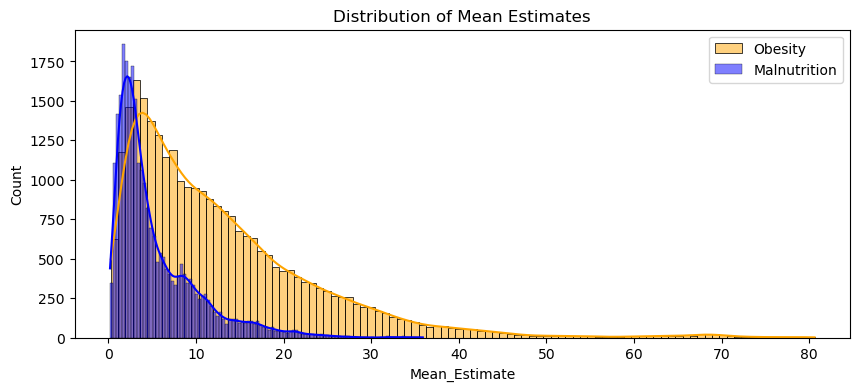

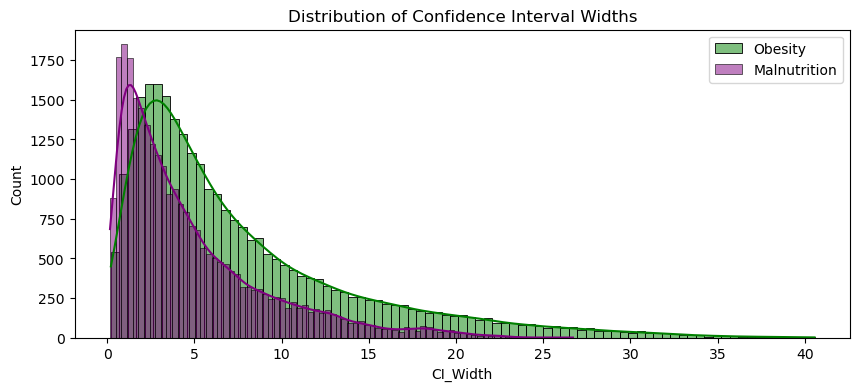

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Mean_Estimate
plt.figure(figsize=(10,4))
sns.histplot(df_obesity['Mean_Estimate'], kde=True, color='orange', label='Obesity')
sns.histplot(df_malnutrition['Mean_Estimate'], kde=True, color='blue', label='Malnutrition')
plt.title('Distribution of Mean Estimates')
plt.legend()
plt.show()

# Distribution of CI Width
plt.figure(figsize=(10,4))
sns.histplot(df_obesity['CI_Width'], kde=True, color='green', label='Obesity')
sns.histplot(df_malnutrition['CI_Width'], kde=True, color='purple', label='Malnutrition')
plt.title('Distribution of Confidence Interval Widths')
plt.legend()
plt.show()


--- Trends Over Time ---

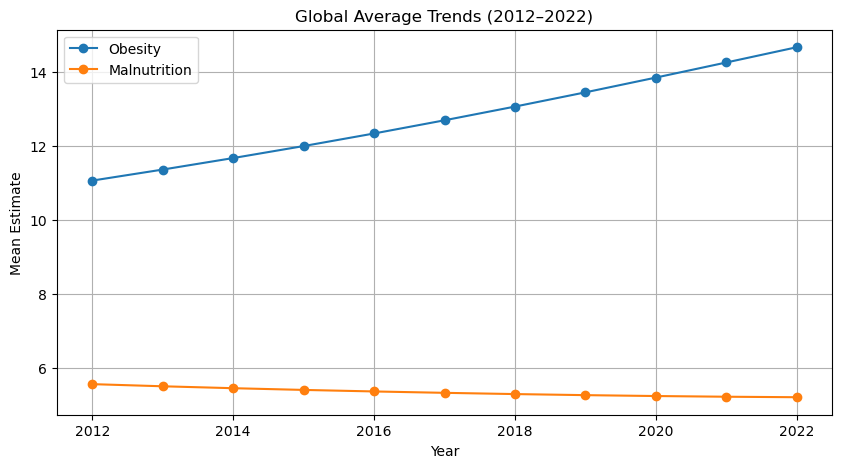

In [93]:
# Average obesity and malnutrition rates per year

obesity_trend = df_obesity.groupby('Year')['Mean_Estimate'].mean()
malnutrition_trend = df_malnutrition.groupby('Year')['Mean_Estimate'].mean()

plt.figure(figsize=(10,5))
obesity_trend.plot(label='Obesity', marker='o')
malnutrition_trend.plot(label='Malnutrition', marker='o')
plt.title('Global Average Trends (2012–2022)')
plt.ylabel('Mean Estimate')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()


--- Regional Comparison ---

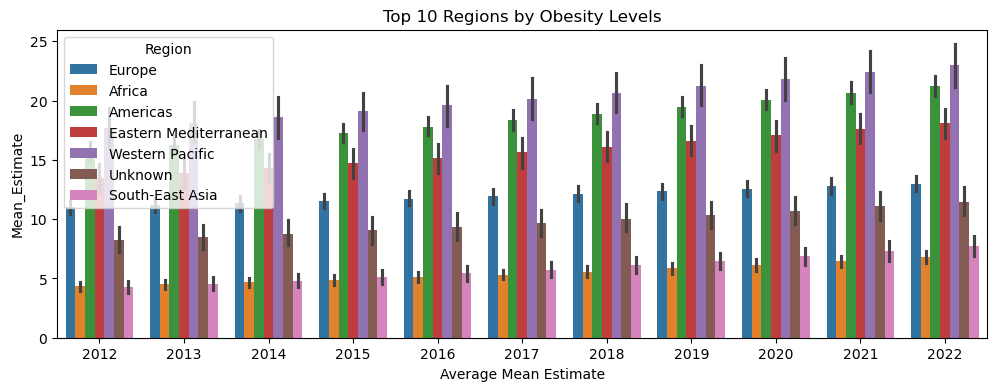

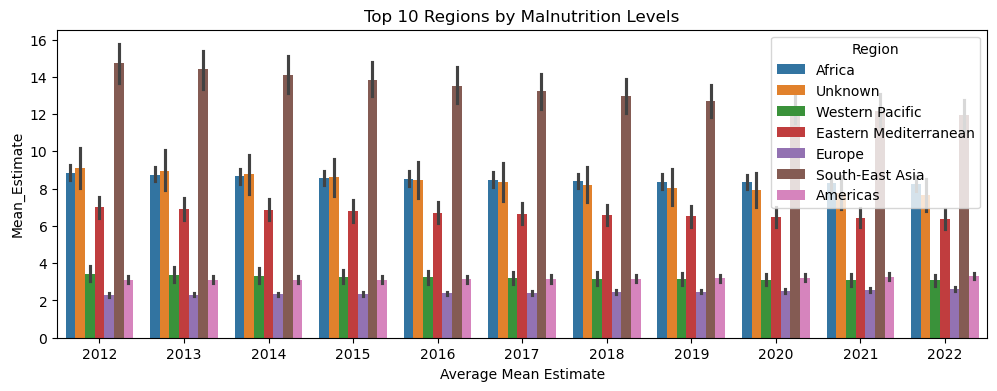

In [105]:
# Top 10 regions by average obesity
top_regions_obesity = df_obesity.groupby('Region')['Mean_Estimate'].mean().sort_values(ascending=False).head(10).index
df_top_regions = df_obesity[df_obesity['Region'].isin(top_regions_obesity)]

# Top 10 regions by average malnutrition
top_regions_malnutrition = df_malnutrition.groupby('Region')['Mean_Estimate'].mean().sort_values(ascending=False).head(10).index
df_mal_top = df_malnutrition[df_malnutrition['Region'].isin(top_regions_malnutrition)]

plt.figure(figsize=(12,4))
sns.barplot(data = df_top_regions, x = 'Year', y = 'Mean_Estimate', hue = 'Region')
plt.title("Top 10 Regions by Obesity Levels")
plt.xlabel("Average Mean Estimate")
plt.show()

plt.figure(figsize=(12,4))
sns.barplot(data = df_mal_top, x = 'Year', y = 'Mean_Estimate', hue = 'Region')
plt.title("Top 10 Regions by Malnutrition Levels")
plt.xlabel("Average Mean Estimate")
plt.show()


--- Obesity Analysis by gender and age group---

C:\Users\Surendar\AppData\Local\Temp\ipykernel_9408\2898664093.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x='Gender', y='Mean_Estimate', hue='age_group', data=df_obesity,


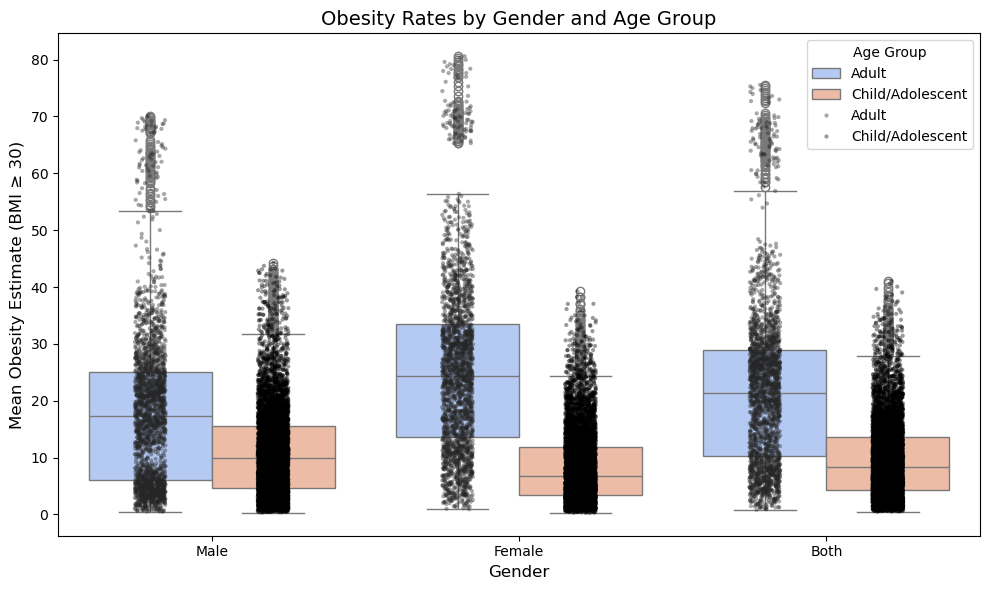

In [117]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Gender', y='Mean_Estimate', hue='age_group', data=df_obesity, palette='coolwarm')
sns.stripplot(x='Gender', y='Mean_Estimate', hue='age_group', data=df_obesity, 
              dodge=True, color='black', size=3, alpha=0.4)
plt.title("Obesity Rates by Gender and Age Group", fontsize=14)
plt.ylabel("Mean Obesity Estimate (BMI ≥ 30)", fontsize=12)
plt.xlabel("Gender", fontsize=12)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()


--- Malnutrition rates by gender and age group ---

C:\Users\Surendar\AppData\Local\Temp\ipykernel_9408\1327267558.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x='Gender', y='Mean_Estimate', hue='age_group', data=df_malnutrition,


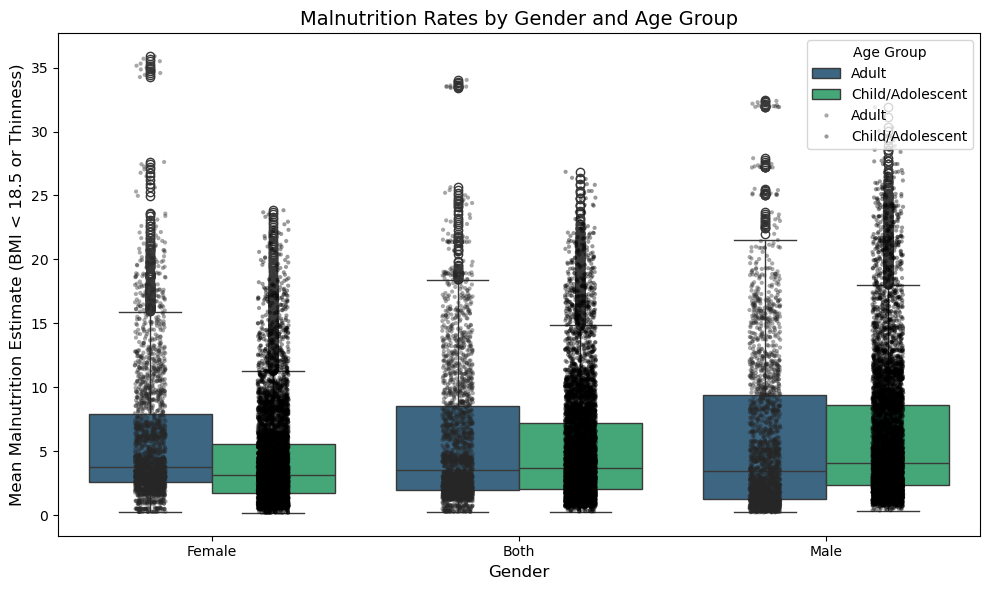

In [119]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Gender', y='Mean_Estimate', hue='age_group', data=df_malnutrition, palette='viridis')
sns.stripplot(x='Gender', y='Mean_Estimate', hue='age_group', data=df_malnutrition,
              dodge=True, color='black', size=3, alpha=0.4)
plt.title("Malnutrition Rates by Gender and Age Group", fontsize=14)
plt.ylabel("Mean Malnutrition Estimate (BMI < 18.5 or Thinness)", fontsize=12)
plt.xlabel("Gender", fontsize=12)
plt.legend(title='Age Group', loc='upper right')
plt.tight_layout()
plt.show()


--- age group comparison ---

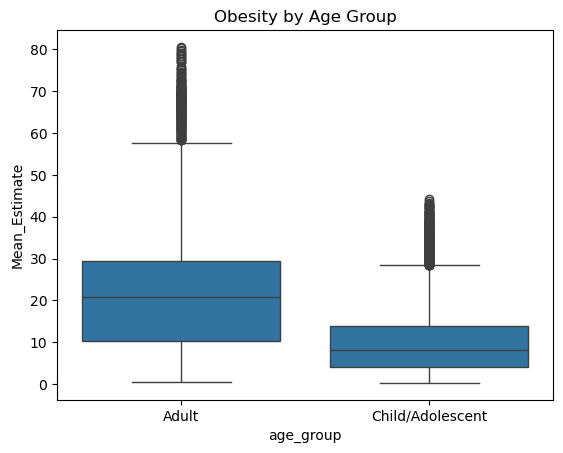

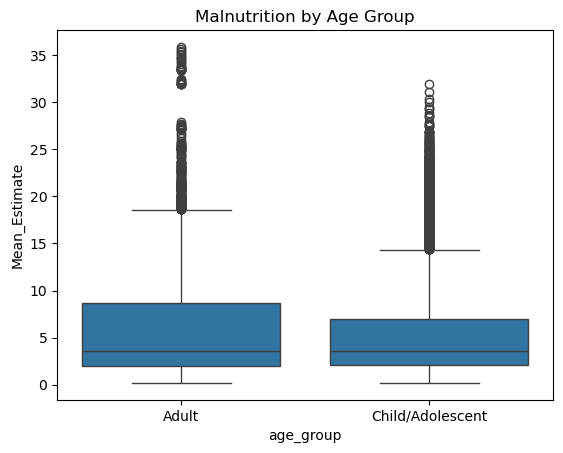

In [121]:
# Age group comparison
sns.boxplot(x='age_group', y='Mean_Estimate', data=df_obesity)
plt.title('Obesity by Age Group')
plt.show()

sns.boxplot(x='age_group', y='Mean_Estimate', data=df_malnutrition)
plt.title('Malnutrition by Age Group')
plt.show()


--- Trend over years by gender ---

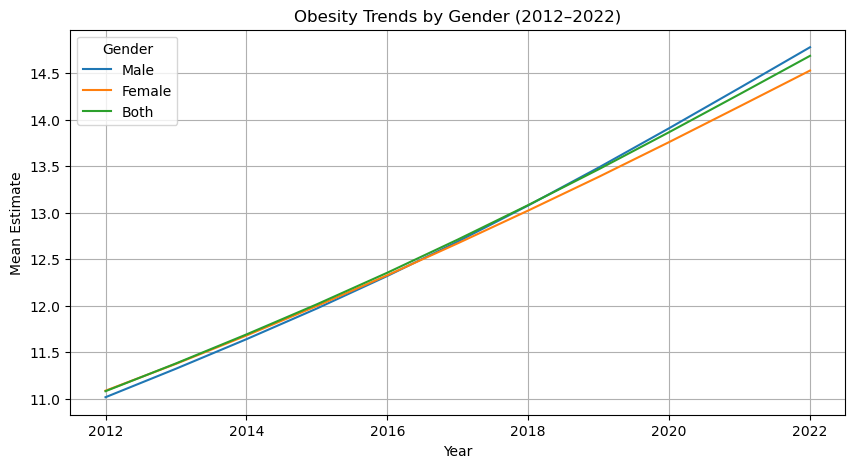

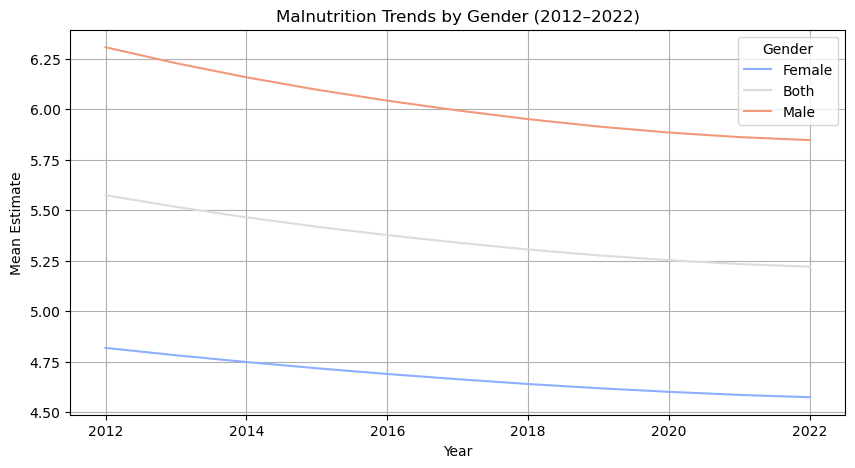

In [129]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_obesity, x='Year', y='Mean_Estimate', hue='Gender', errorbar=None)
plt.title('Obesity Trends by Gender (2012–2022)')
plt.ylabel('Mean Estimate')
plt.xlabel('Year')
plt.legend(title='Gender')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(data=df_malnutrition, x='Year', y='Mean_Estimate', hue='Gender', errorbar=None, palette='coolwarm')
plt.title('Malnutrition Trends by Gender (2012–2022)')
plt.ylabel('Mean Estimate')
plt.xlabel('Year')
plt.legend(title='Gender')
plt.grid(True)
plt.show()


--- Trends over year by region ---

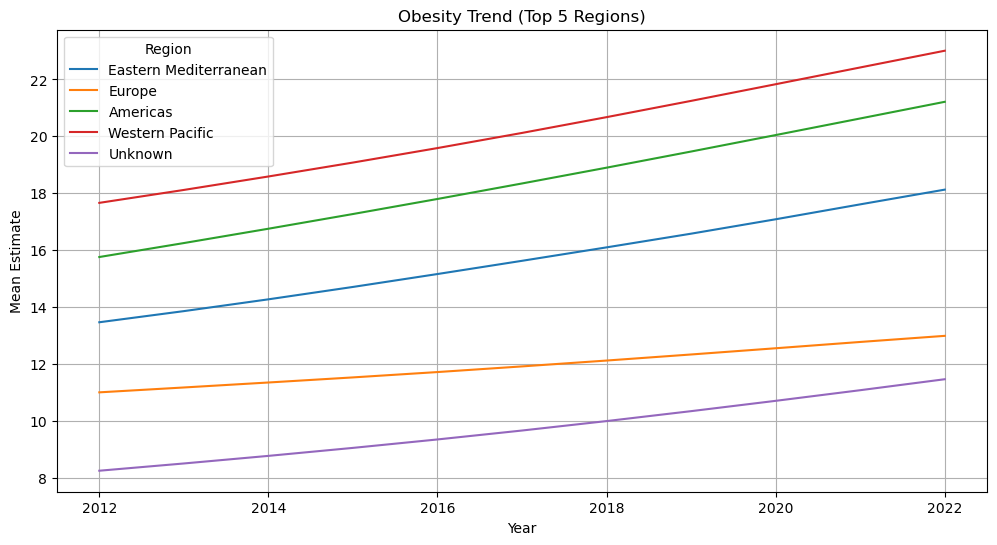

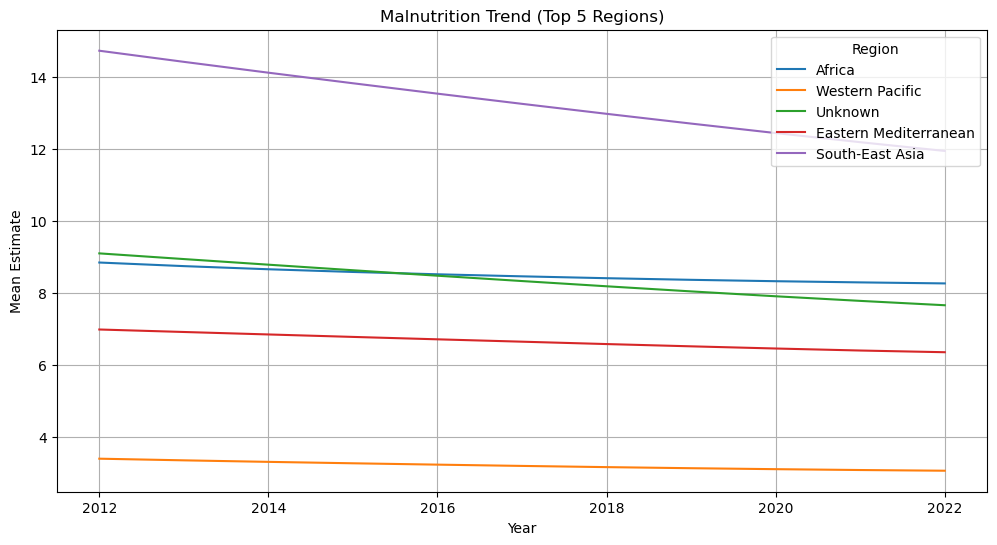

In [127]:
# Pick top 5 regions with highest average obesity
top_regions = df_obesity.groupby('Region')['Mean_Estimate'].mean().sort_values(ascending=False).head(5).index
df_top_regions = df_obesity[df_obesity['Region'].isin(top_regions)]

plt.figure(figsize=(12,6))
sns.lineplot(data=df_top_regions, x='Year', y='Mean_Estimate', hue='Region', errorbar=None)
plt.title('Obesity Trend (Top 5 Regions)')
plt.ylabel('Mean Estimate')
plt.xlabel('Year')
plt.legend(title='Region')
plt.grid(True)
plt.show()


top_mal_regions = df_malnutrition.groupby('Region')['Mean_Estimate'].mean().sort_values(ascending=False).head(5).index
df_mal_top = df_malnutrition[df_malnutrition['Region'].isin(top_mal_regions)]

plt.figure(figsize=(12,6))
sns.lineplot(data=df_mal_top, x='Year', y='Mean_Estimate', hue='Region', errorbar=None)
plt.title('Malnutrition Trend (Top 5 Regions)')
plt.ylabel('Mean Estimate')
plt.xlabel('Year')
plt.legend(title='Region')
plt.grid(True)
plt.show()


Line Plot – Trends Over Time (Obesity or Malnutrition by Region)

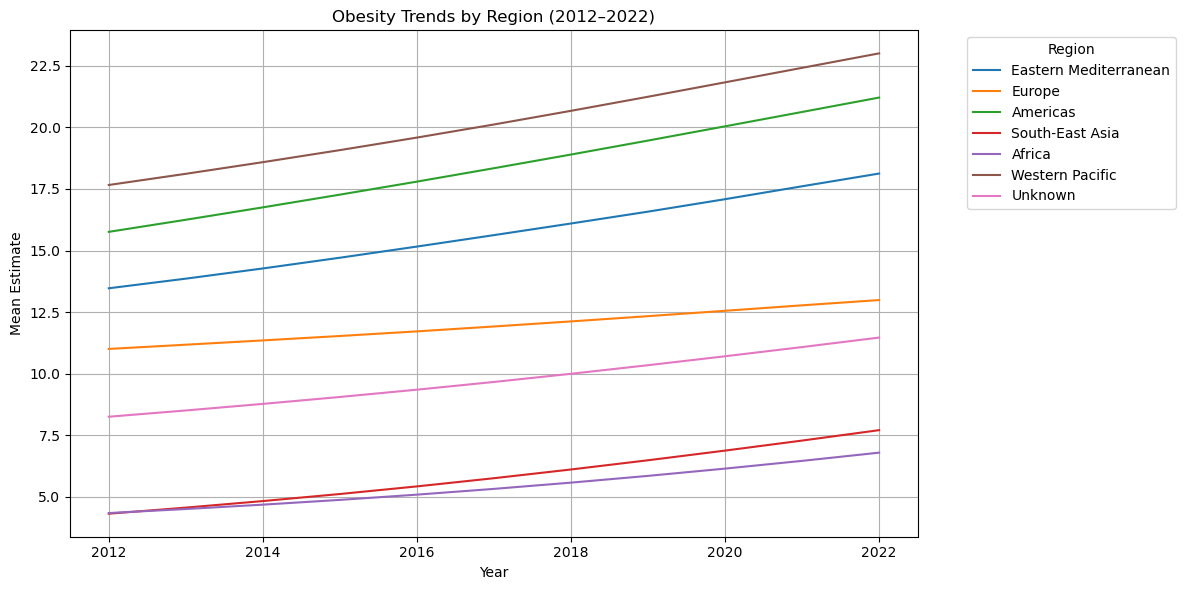

In [131]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_obesity, x='Year', y='Mean_Estimate', hue='Region', errorbar=None)
plt.title('Obesity Trends by Region (2012–2022)')
plt.xlabel('Year')
plt.ylabel('Mean Estimate')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


 Bar Chart – Top 10 Countries by Obesity Rate (Latest Year)
 Bar Chart – Bottom 10 Countries by Malnutrition Rate

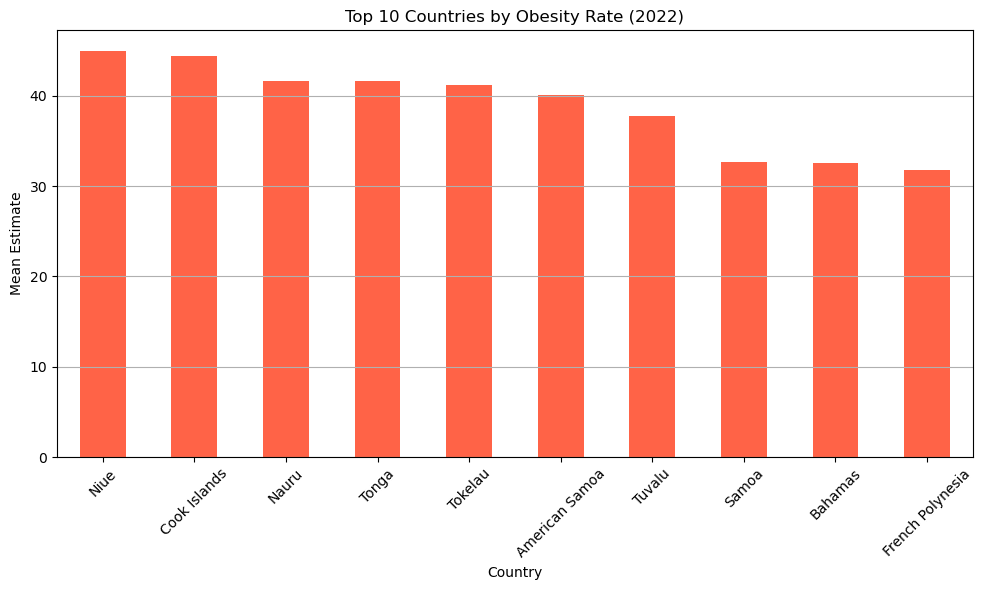

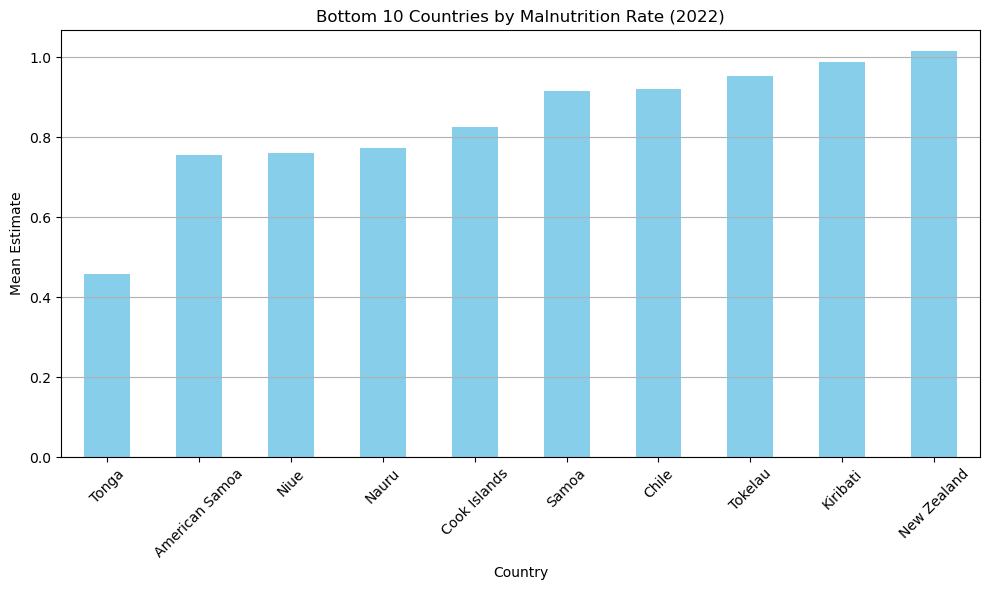

In [133]:
latest_year = df_obesity['Year'].max()
top_countries = df_obesity[df_obesity['Year'] == latest_year].groupby('Country')['Mean_Estimate'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_countries.plot(kind='bar', color='tomato')
plt.title(f'Top 10 Countries by Obesity Rate ({latest_year})')
plt.xlabel('Country')
plt.ylabel('Mean Estimate')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


latest_year = df_malnutrition['Year'].max()
bottom_countries = df_malnutrition[df_malnutrition['Year'] == latest_year].groupby('Country')['Mean_Estimate'].mean().sort_values().head(10)

plt.figure(figsize=(10,6))
bottom_countries.plot(kind='bar', color='skyblue')
plt.title(f'Bottom 10 Countries by Malnutrition Rate ({latest_year})')
plt.xlabel('Country')
plt.ylabel('Mean Estimate')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Box Plot – Variability in Obesity by Region

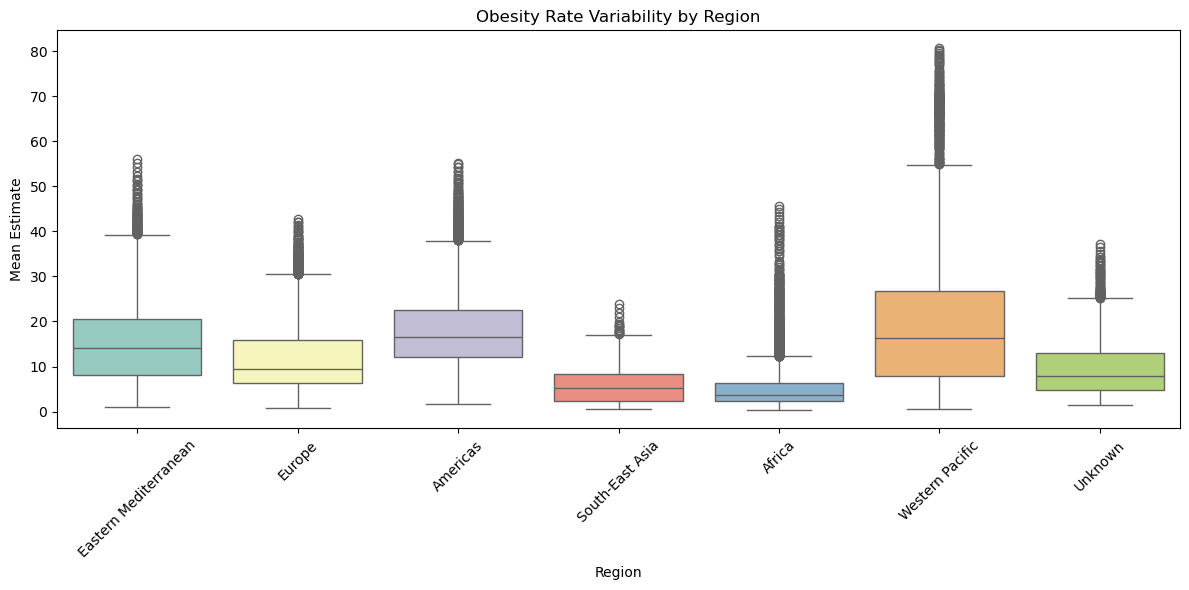

In [139]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_obesity, x='Region', y='Mean_Estimate', hue ='Region', palette='Set3')
plt.title('Obesity Rate Variability by Region')
plt.xlabel('Region')
plt.ylabel('Mean Estimate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Heatmap – Obesity Mean by Region & Year

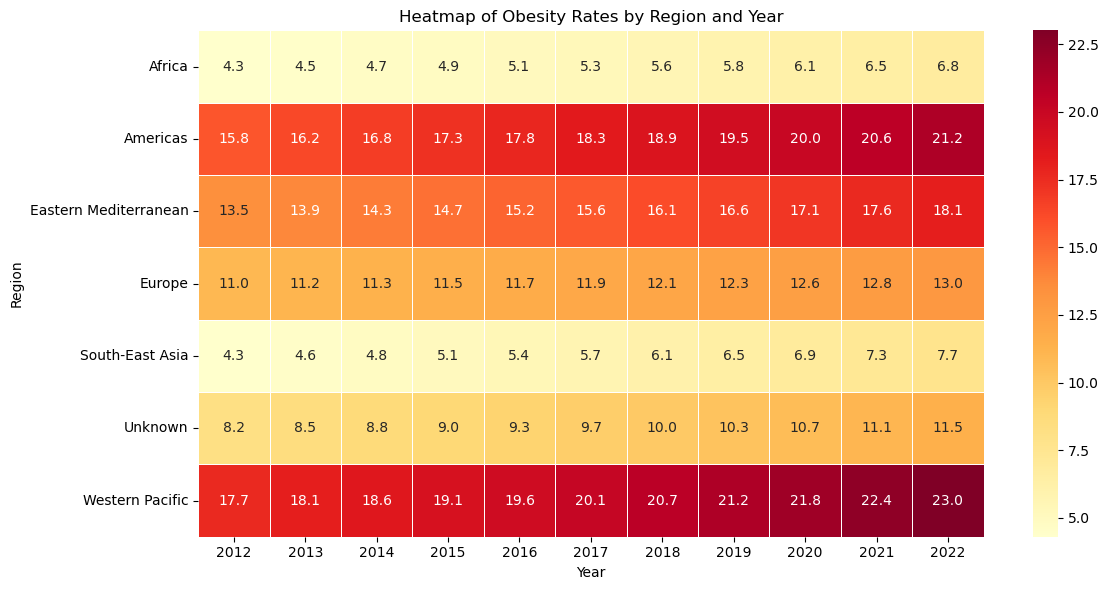

In [141]:
heat_data = df_obesity.pivot_table(values='Mean_Estimate', index='Region', columns='Year', aggfunc='mean')

plt.figure(figsize=(12,6))
sns.heatmap(heat_data, cmap='YlOrRd', annot=True, fmt=".1f", linewidths=0.5)
plt.title('Heatmap of Obesity Rates by Region and Year')
plt.ylabel('Region')
plt.xlabel('Year')
plt.tight_layout()
plt.show()


Scatter Plot – Obesity vs. Malnutrition by Country (Same Year)

C:\Users\Surendar\AppData\Local\Temp\ipykernel_9408\572785766.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


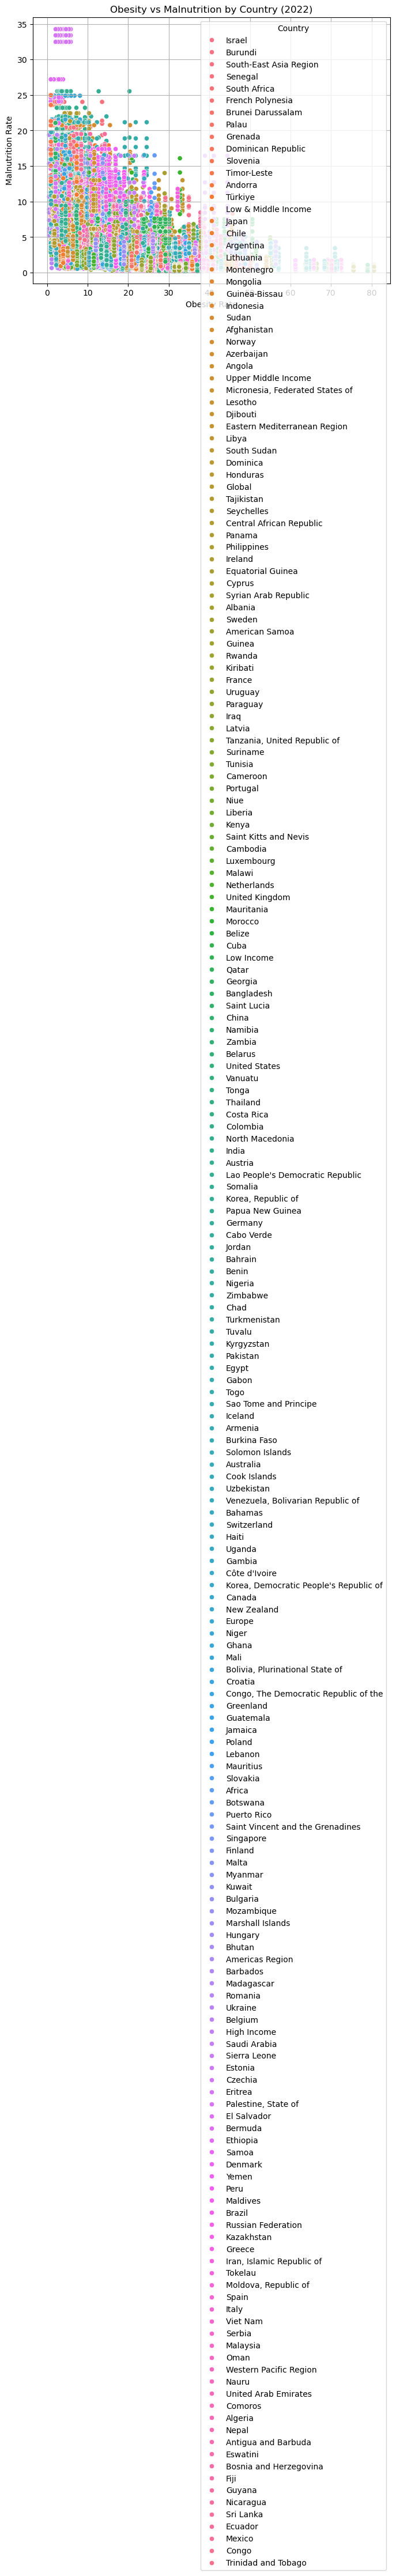

In [143]:
merged = pd.merge(
    df_obesity[df_obesity['Year'] == latest_year][['Country', 'Mean_Estimate']],
    df_malnutrition[df_malnutrition['Year'] == latest_year][['Country', 'Mean_Estimate']],
    on='Country',
    suffixes=('_obesity', '_malnutrition')
)

plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x='Mean_Estimate_obesity', y='Mean_Estimate_malnutrition', hue='Country')
plt.title(f'Obesity vs Malnutrition by Country ({latest_year})')
plt.xlabel('Obesity Rate')
plt.ylabel('Malnutrition Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
---  Insert Data into SQL ---

In [145]:
pip install mysql-connector-python


Note: you may need to restart the kernel to use updated packages.


In [147]:
import mysql.connector


In [ ]:
#Mysql Database connection

db_connection = mysql.connector.connect(
    host='localhost',
    user='root',
    password='998800',
    database='nasa_db'
)

if db_connection.is_connected:
    print("DATABASE SUCCESSFULLY CONNECTED ✅")

else:
    print("ERROR: DATABASE not connected ❌")

cursor = db_connection.cursor()

--- Create tables ---

In [ ]:
# Create obesity table
cursor.execute("""
CREATE TABLE IF NOT EXISTS obesity (
    Region VARCHAR(100),
    Gender VARCHAR(20),
    Year INT,
    LowerBound FLOAT,
    UpperBound FLOAT,
    Mean_Estimate FLOAT,
    Country VARCHAR(100),
    age_group VARCHAR(30),
    CI_Width FLOAT,
    obesity_level VARCHAR(20)
);
""")

# Create malnutrition table
cursor.execute("""
CREATE TABLE IF NOT EXISTS malnutrition (
    Region VARCHAR(100),
    Gender VARCHAR(20),
    Year INT,
    LowerBound FLOAT,
    UpperBound FLOAT,
    Mean_Estimate FLOAT,
    Country VARCHAR(100),
    age_group VARCHAR(30),
    CI_Width FLOAT,
    malnutrition_level VARCHAR(20)
);
""")

db_connection.commit()

In [ ]:
# insert values to tables

cursor = db_connection.cursor()

for index, row in df_obesity.iterrows():
    cursor.execute("""
        INSERT INTO obesity (Region, Gender, Year, LowerBound, UpperBound, Mean_Estimate, Country, age_group, CI_Width, obesity_level)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """, (
        row['Region'],
        row['Gender'],
        int(row['Year']),
        row['LowerBound'],
        row['UpperBound'],
        row['Mean_Estimate'],
        row['Country'],
        row['age_group'],
        row['CI_Width'],
        row['obesity_level']
    ))

db_connection.commit()

In [ ]:
# insert values to tables

cursor = db_connection.cursor()

for index, row in df_malnutrition.iterrows():
    cursor.execute("""
        INSERT INTO malnutrition (Region, Gender, Year, LowerBound, UpperBound, Mean_Estimate, Country, age_group, CI_Width, malnutrition_level)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """, (
        row['Region'],
        row['Gender'],
        int(row['Year']),
        row['LowerBound'],
        row['UpperBound'],
        row['Mean_Estimate'],
        row['Country'],
        row['age_group'],
        row['CI_Width'],
        row['malnutrition_level']
    ))

db_connection.commit()

cursor.close()
db_connection.close()